## Piecewise exponential models and creating custom models

This section will be easier if we recall our three mathematical "creatures" and the relationships between them. First is the survival function, $S(t)$, that represents the probability of living past some time, $t$. Next is the _always non-negative and non-decreasing_ cumulative hazard function, $H(t)$. Its relation to $S(t)$ is:

$$ S(t) = \exp\left(-H(t)\right)$$

Finally, the hazard function, $h(t)$, is the derivative of the cumulative hazard: 

$$h(t) = \frac{dH(t)}{dt}$$

which has the immediate relation to the survival function:

$$S(t) = \exp\left(-\int_{0}^t h(s) ds\right)$$

Notice that any of the three absolutely defines the other two. Some situations make it easier to define one vs the others. For example, in the Cox model, it's easiest to work with the hazard, $h(t)$. In this section on parametric univariate models, it'll be easiest to work with the cumulative hazard. This is because of an asymmetry in math: derivatives are much easier to compute than integrals. So, if we define the cumulative hazard, both the hazard and survival function are much easier to reason about versus if we define the hazard and ask questions about the other two.

First, let's revisit some simpler parametric models. 

#### The Exponential model

Recall that the Exponential model has a constant hazard, that is:

$$ h(t) = \frac{1}{\lambda} $$

which implies that the cumulative hazard, $H(t)$, has a pretty simple form: $H(t) = \frac{t}{\lambda}$. Below we fit this model to some survival data. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from lifelines.datasets import load_waltons
waltons = load_waltons()
T, E = waltons['T'], waltons['E']

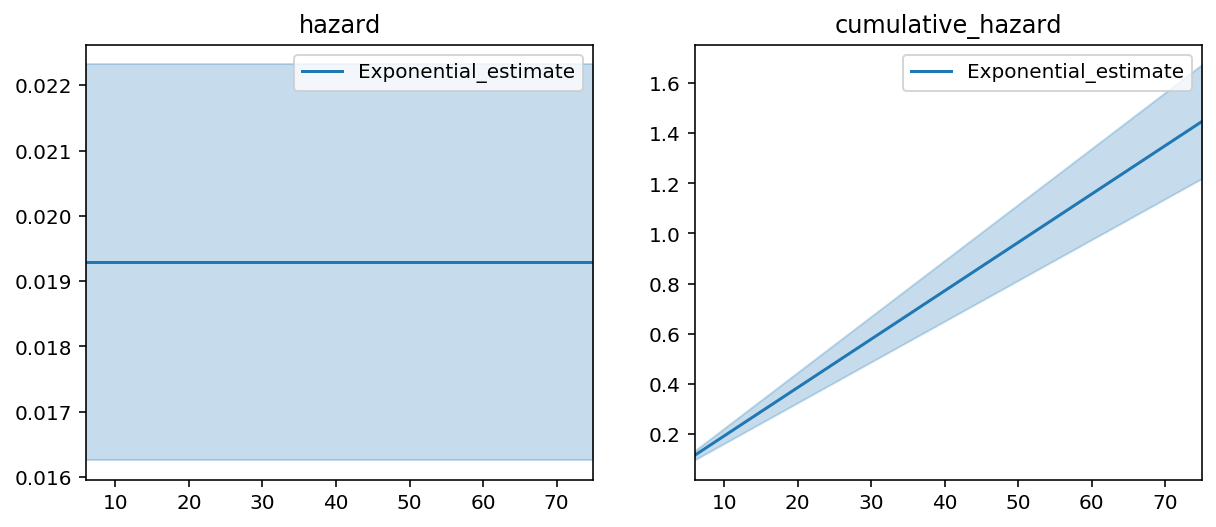

In [2]:
from lifelines import ExponentialFitter

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

epf = ExponentialFitter().fit(T, E)
epf.plot_hazard(ax=ax[0])
epf.plot_cumulative_hazard(ax=ax[1])

ax[0].set_title("hazard"); ax[1].set_title("cumulative_hazard")

epf.print_summary(3)

This model does a poor job of fitting to our data. If I fit a _non-parametric_ model, like the Nelson-Aalen model, to this data, the Exponential's lack of fit is very obvious. 

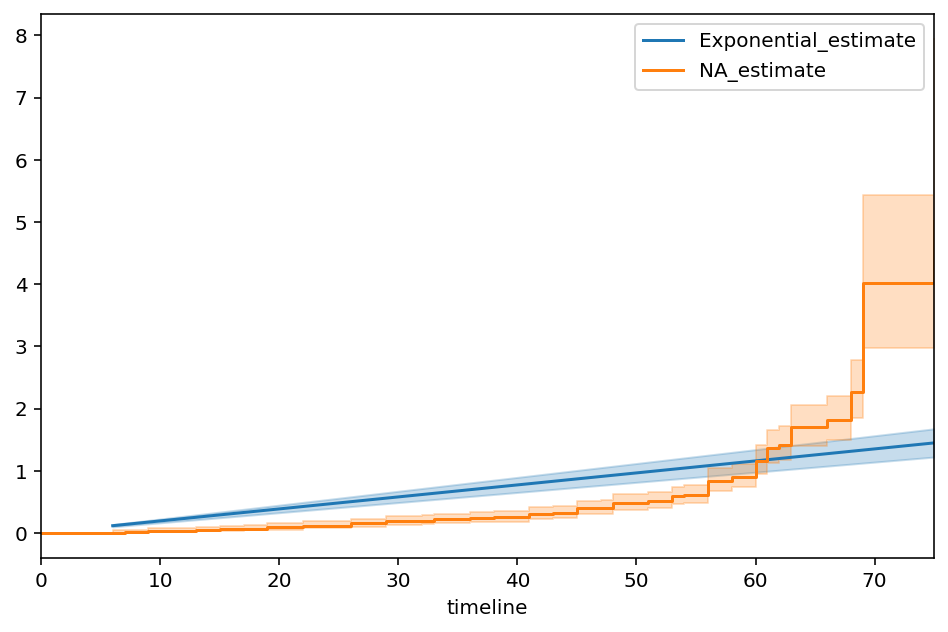

In [3]:
from lifelines import NelsonAalenFitter

ax = epf.plot(figsize=(8,5))

naf = NelsonAalenFitter().fit(T, E)
ax = naf.plot(ax=ax)
plt.legend()

It should be clear that the single parameter model is just averaging the hazards over the entire time period. In reality though, the true hazard rate exhibits some complex non-linear behaviour.

#### Piecewise Exponential models

What if we could break out model into different time periods, and fit an exponential model to each of those? For example, we define the hazard as:

$$ 
h(t) = \begin{cases}
        \lambda_0,  & \text{if $t \le \tau_0$} \\
        \lambda_1 & \text{if $\tau_0 < t \le \tau_1$} \\
        \lambda_2 & \text{if $\tau_1 < t \le \tau_2$} \\
        ... 
      \end{cases}
$$

This model should be flexible enough to fit better to our dataset. 

The cumulative hazard is only slightly more complicated, but not too much and can still be defined in Python. In _lifelines_, univariate models are constructed such that one _only_ needs to define the cumulative hazard model with the parameters of interest, and all the hard work of fitting, creating confidence intervals, plotting, etc. is taken care. 

For example, _lifelines_ has implemented the `PiecewiseExponentialFitter` model. Internally, the code is a single function that defines the cumulative hazard. The user specifies where they believe the "breaks" are, and _lifelines_ estimates the best $\lambda_i$. 


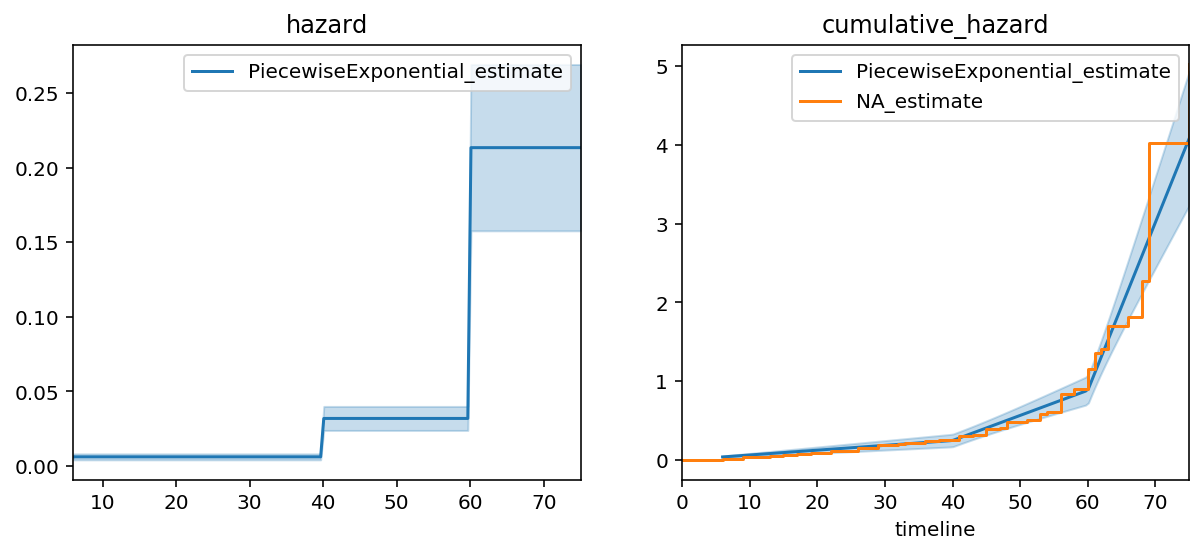

In [4]:
from lifelines import PiecewiseExponentialFitter

# looking at the above plot, I think there may be breaks at t=40 and t=60. 
pf = PiecewiseExponentialFitter(breakpoints=[40, 60]).fit(T, E)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax = pf.plot(ax=axs[1])
pf.plot_hazard(ax=axs[0])

ax = naf.plot(ax=ax, ci_show=False)
axs[0].set_title("hazard"); axs[1].set_title("cumulative_hazard")

pf.print_summary(3)


We can see a much better fit in this model. A quantitative measure of fit is to compare the log-likelihood between exponential model and the piecewise exponential model (higher is better). The log-likelihood went from -772 to -647, respectively. We could keep going and add more and more breakpoints, but that would end up overfitting to the data. 

#### Univarite models in _lifelines_

I mentioned that the `PiecewiseExponentialFitter` was implemented using only its cumulative hazard function. This is not a lie. _lifelines_ has very general semantics for univariate fitters. For example, this is how the entire `ExponentialFitter` is implemented:

```python
class ExponentialFitter(ParametricUnivariateFitter):

    _fitted_parameter_names = ["lambda_"]

    def _cumulative_hazard(self, params, times):
        lambda_ = params[0]
        return times / lambda_
```

We only need to specify the cumulative hazard function because of the 1:1:1 relationship between the cumulative hazard function and the survival function and the hazard rate. From there, _lifelines_ handles the rest. 


#### Defining our own survival models


To show off the flexibility of _lifelines_ univariate models, we'll create a brand new, never before seen, survival model. Looking at the Nelson-Aalen fit, the cumulative hazard looks looks like their might be an asymptote at $t=80$. This may correspond to an absolute upper limit of subjects' lives. Let's start with that functional form.

$$ H_1(t; \alpha) = \frac{\alpha}{(80 - t)} $$

We subscript $1$ because we'll investigate other models. In a _lifelines_ univariate model, this is defined in the following code. 

**Important**: in order to compute derivatives, you must use the numpy imported from the `autograd` library. This is a thin wrapper around the original numpy. Note the `import autograd.numpy as np` below. 

In [5]:
from lifelines.fitters import ParametricUnivariateFitter

import autograd.numpy as np

class InverseTimeHazardFitter(ParametricUnivariateFitter):
    
    # we tell the model what we want the names of the unknown parameters to be
    _fitted_parameter_names = ['alpha_']

    
    # this is the only function we need to define. It always takes two arguments:
    #   params: an iterable that unpacks the parameters you'll need in the order of _fitted_parameter_names
    #   times: a vector of times that will be passed in.
    def _cumulative_hazard(self, params, times):
        alpha = params[0]
        return alpha /(80 - times)

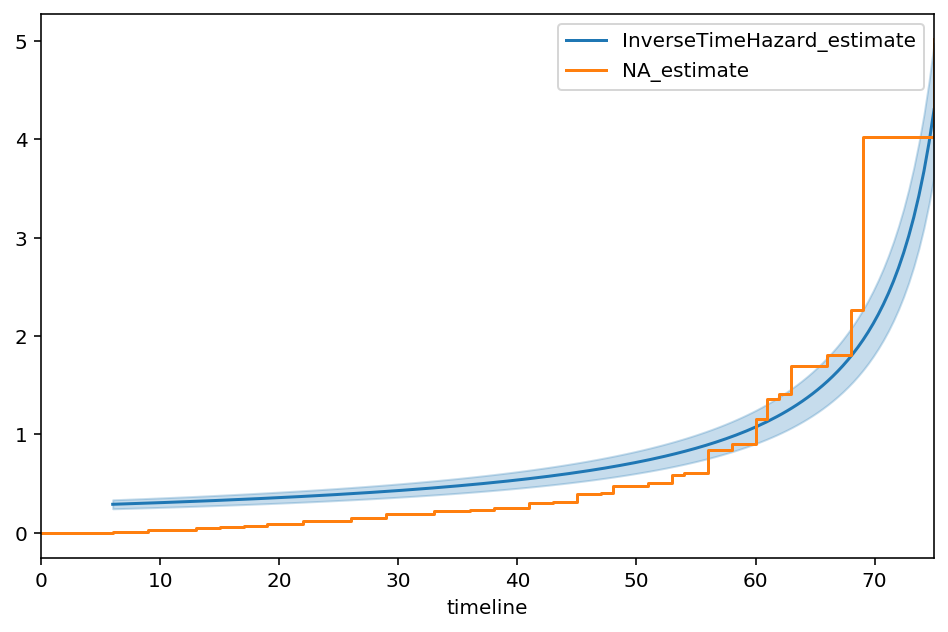

In [6]:
itf = InverseTimeHazardFitter()
itf.fit(T, E)
itf.print_summary()

ax = itf.plot(figsize=(8,5))
ax = naf.plot(ax=ax, ci_show=False)
plt.legend()

The best fit of the model to the data is:

$$H_1(t) = \frac{21.51}{80-t}$$

Our choice of 80 as an asymptote was maybe mistaken, so let's allow the asymptote to be another parameter:

$$ H_2(t; \alpha, \beta) = \frac{\alpha}{\beta-t} $$

If we define the model this way, we need to add a bound to the values that $\beta$ can take. Obviously it can't be smaller than or equal to the maximum observed duration. Generally, the cumulative hazard _must be positive and non-decreasing_. Otherwise the model fit will hit convergence problems. 

In [7]:
class TwoParamInverseTimeHazardFitter(ParametricUnivariateFitter):
    
    _fitted_parameter_names = ['alpha_', 'beta_']
    
    # Sequence of (min, max) pairs for each element in x. None is used to specify no bound
    _bounds = [(0, None), (75.0001, None)]
    
    def _cumulative_hazard(self, params, times):
        alpha, beta = params
        return alpha / (beta - times)

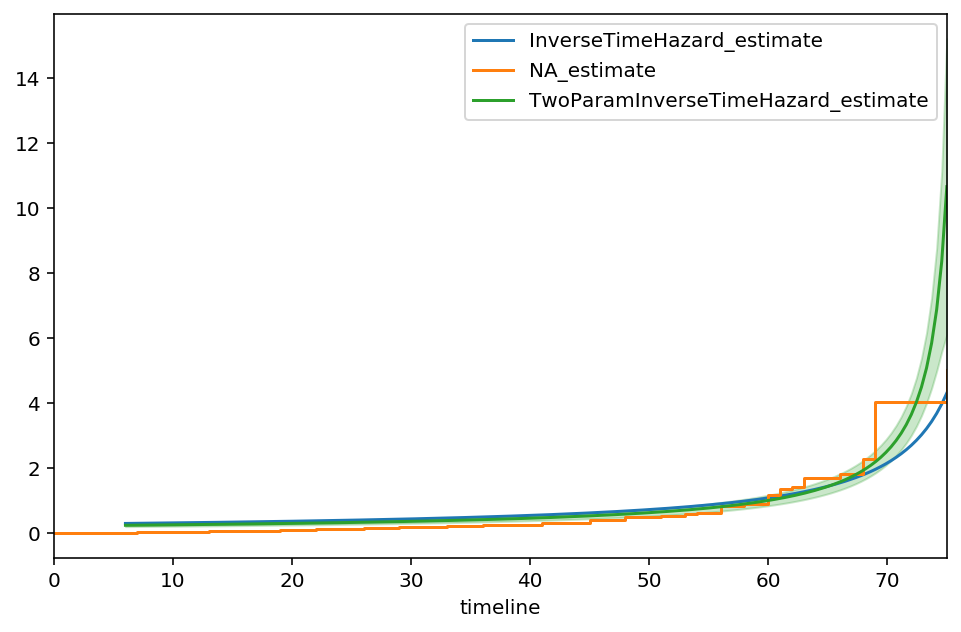

In [8]:
two_f = TwoParamInverseTimeHazardFitter()
two_f.fit(T, E)
two_f.print_summary()

ax = itf.plot(ci_show=False, figsize=(8,5))
ax = naf.plot(ax=ax, ci_show=False)
two_f.plot(ax=ax)
plt.legend()

From the output, we see that the value of 76.55 is the suggested asymptote, that is:

$$H_2(t) = \frac{16.50} {76.55  - t}$$

The curve also appears to track against the Nelson-Aalen model better too. Let's try one additional parameter, $\gamma$, some sort of measure of decay. 

$$H_3(t; \alpha, \beta, \gamma) = \frac{\alpha}{(\beta-t)^\gamma} $$


In [9]:
from lifelines.fitters import ParametricUnivariateFitter

class ThreeParamInverseTimeHazardFitter(ParametricUnivariateFitter):
    
    _fitted_parameter_names = ['alpha_', 'beta_', 'gamma_']
    _bounds = [(0, None), (75.0001, None), (0, None)]
    
    # this is the only function we need to define. It always takes two arguments:
    #   params: an iterable that unpacks the parameters you'll need in the order of _fitted_parameter_names
    #   times: a numpy vector of times that will be passed in by the optimizer
    def _cumulative_hazard(self, params, times):
        a, b, c = params
        return a / (b - times) ** c

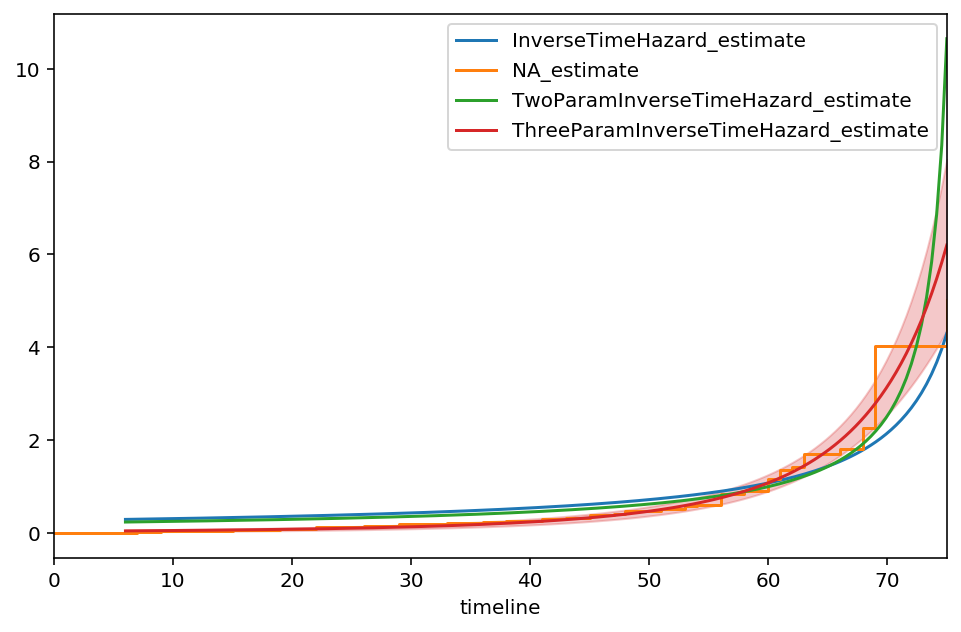

In [10]:
three_f = ThreeParamInverseTimeHazardFitter()
three_f.fit(T, E)
three_f.print_summary()

ax = itf.plot(ci_show=False, figsize=(8,5))
ax = naf.plot(ax=ax, ci_show=False)
ax = two_f.plot(ax=ax, ci_show=False)
ax = three_f.plot(ax=ax)
plt.legend()

Our new asymptote is at $t\approx 100, \text{c.i.}=(87, 112)$. The model appears to fit the early times better than the previous models as well, however our $\alpha$ parameter has more uncertainty now. Continuing to add parameters isn't advisable, as we will overfit to the data. 

Why fit parametric models anyways? Taking a step back, we are fitting parametric models and comparing them to the non-parametric Nelson-Aalen. Why not just always use the Nelson-Aalen model? 

1) Sometimes we have scientific motivations to use a parametric model. That is, using domain knowledge, we may know the system has a parametric model and we wish to fit to that model. 

2) In a parametric model, we are borrowing information from _all_ observations to determine the best parameters. To make this more clear, imagine taking a single observation and changing it's value wildly. The fitted parameters would change as well. On the other hand, imagine doing the same for a non-parametric model. In this case, only the local survival function or hazard function would change. Because parametric models can borrow information from all observations, and there are much _fewer_ unknowns than a non-parametric model, parametric models are said to be more _statistically efficient._ 

3) Extrapolation: non-parametric models are not easily extended to values outside the observed data. On the other hand, parametric models have no problem with this. However, extrapolation outside observed values is a very dangerous activity. 

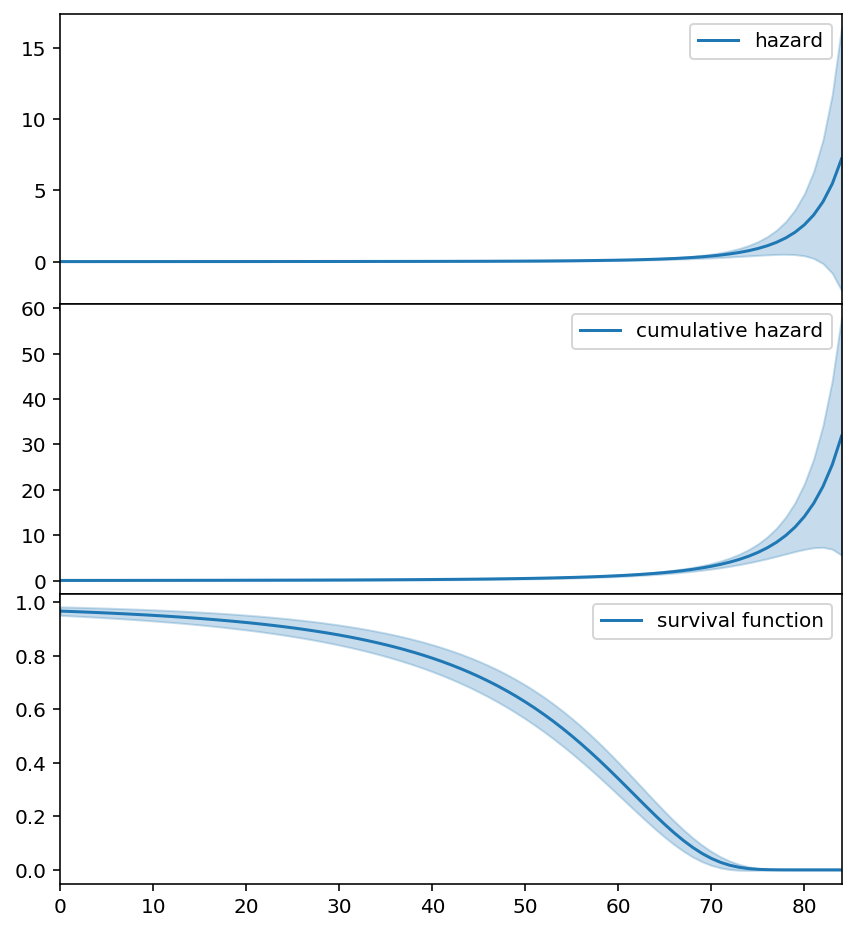

In [11]:
fig, axs = plt.subplots(3, figsize=(7, 8), sharex=True)

new_timeline = np.arange(0, 85)

three_f = ThreeParamInverseTimeHazardFitter().fit(T, E, timeline=new_timeline)

three_f.plot_hazard(label='hazard', ax=axs[0]).legend()
three_f.plot_cumulative_hazard(label='cumulative hazard',  ax=axs[1]).legend()
three_f.plot_survival_function(label='survival function',  ax=axs[2]).legend()

fig.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()


### 3-parameter Weibull distribution

We can easily extend the built-in Weibull model (`lifelines.WeibullFitter`) to include a new _location_ parameter:

$$ H(t) = \left(\frac{t - \theta}{\lambda}\right)^\rho $$

(When $\theta = 0$, this is just the 2-parameter case again). In *lifelines* custom models, this looks like:

In [90]:
import autograd.numpy as np
from autograd.scipy.stats import norm

# I'm shifting this to exaggerate the effect 
T_ = T + 10

class ThreeParameterWeibullFitter(ParametricUnivariateFitter):

    _fitted_parameter_names = ["lambda_", "rho_", "theta_"]
    _bounds = [(0, None), (0, None), (0, T.min()-0.001)]

    def _cumulative_hazard(self, params, times):
        lambda_, rho_, theta_ = params
        return ((times - theta_) / lambda_) ** rho_


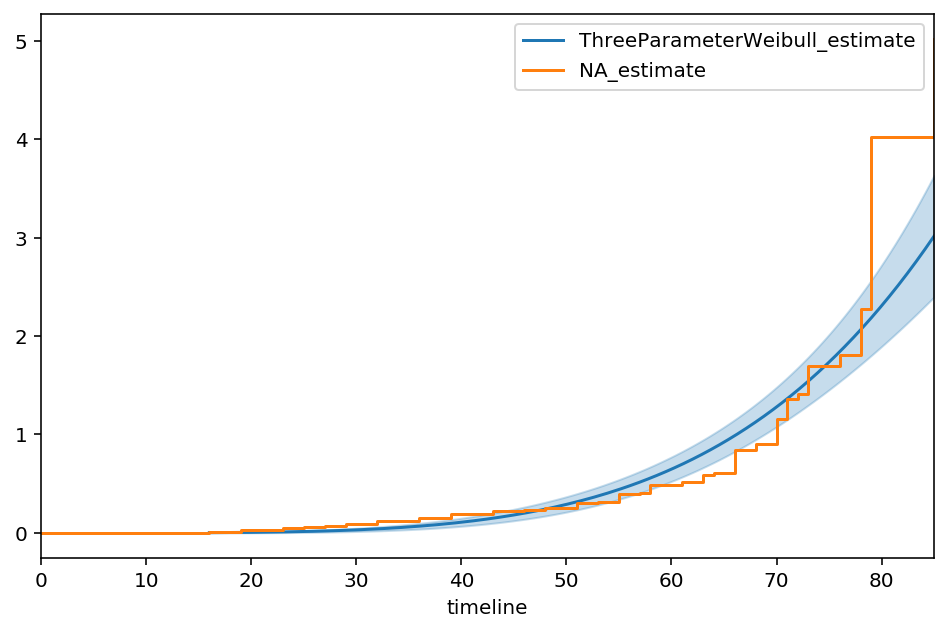

In [92]:
tpw = ThreeParameterWeibullFitter()
tpw.fit(T_, E)
tpw.print_summary()
ax = tpw.plot_cumulative_hazard(figsize=(8,5))
ax = NelsonAalenFitter().fit(T_, E).plot(ax=ax, ci_show=False)


### Inverse Gaussian distribution

The inverse Gaussian distribution is another popular model for survival analysis. Unlike other model, it's hazard does not asympotically converge to 0, allowing for a long tail of survival. Let's model this, using the same parameterization from [Wikipedia](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)

In [93]:
from autograd.scipy.stats import norm


class InverseGaussianFitter(ParametricUnivariateFitter):
    _fitted_parameter_names = ['lambda_', 'mu_']
    
    def _cumulative_density(self, params, times):
        mu_, lambda_ = params
        v = norm.cdf(np.sqrt(lambda_ / times) * (times / mu_ - 1), loc=0, scale=1) + \
               np.exp(2 * lambda_ / mu_) * norm.cdf(-np.sqrt(lambda_ / times) * (times / mu_ + 1), loc=0, scale=1)
        return v

    def _cumulative_hazard(self, params, times):
        return -np.log(1-np.clip(self._cumulative_density(params, times), 1e-15, 1-1e-15))

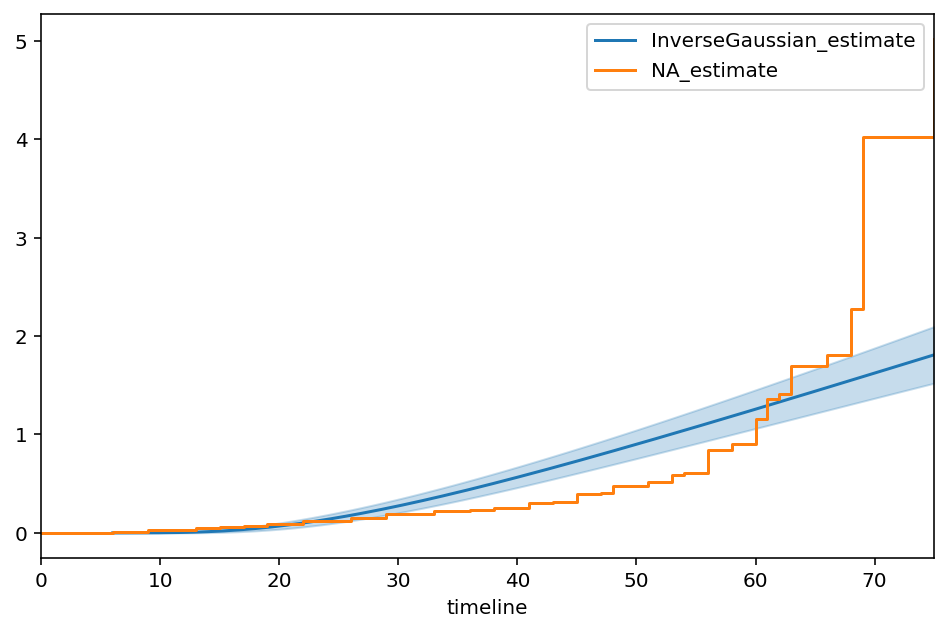

In [94]:
igf = InverseGaussianFitter()
igf.fit(T, E)
igf.print_summary()
ax = igf.plot_cumulative_hazard(figsize=(8,5))
ax = NelsonAalenFitter().fit(T, E).plot(ax=ax, ci_show=False)


### Gompertz 

In [95]:
class GompertzFitter(ParametricUnivariateFitter):
    # this parameterization is slightly different than wikipedia. 
    _fitted_parameter_names = ['nu_', 'b_']

    def _cumulative_hazard(self, params, times):
        nu_, b_ = params
        return nu_ * (np.expm1(times * b_))

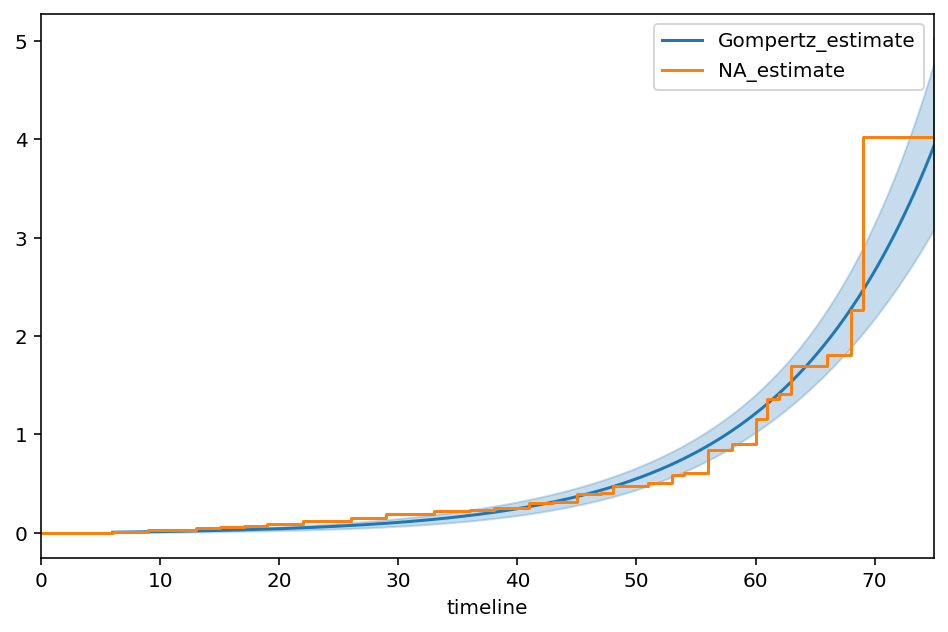

In [96]:
T, E = waltons['T'], waltons['E']

ggf = GompertzFitter()
ggf.fit(T, E)
ggf.print_summary()
ax = ggf.plot_cumulative_hazard(figsize=(8,5))
ax = NelsonAalenFitter().fit(T, E).plot(ax=ax, ci_show=False)

### APGW

From the paper, "A Flexible Parametric Modelling Framework for Survival Analysis", https://arxiv.org/pdf/1901.03212.pdf

In [97]:
class APGWFitter(ParametricUnivariateFitter):
    # this parameterization is slightly different than wikipedia. 
    _fitted_parameter_names = ['kappa_', 'gamma_', 'phi_']

    def _cumulative_hazard(self, params, t):
        kappa_, phi_, gamma_ = params
        return (kappa_ + 1) / kappa_ * ((1 + ((phi_ * t) ** gamma_) /(kappa_ + 1)) ** kappa_ -1)


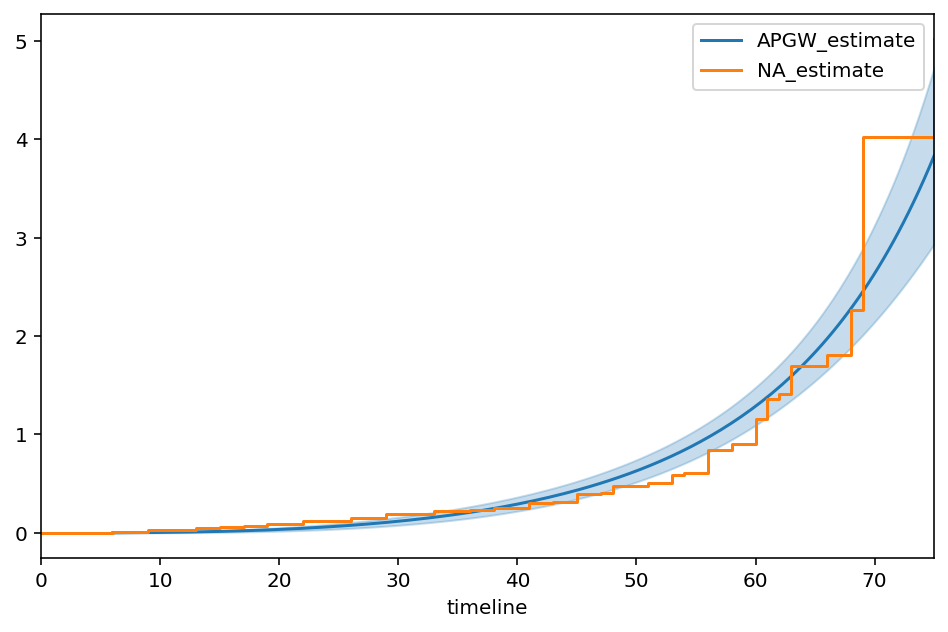

In [98]:
apg = APGWFitter()
apg.fit(T, E)
apg.print_summary(2)
ax = apg.plot_cumulative_hazard(figsize=(8,5))
ax = NelsonAalenFitter().fit(T, E).plot(ax=ax, ci_show=False)


### Bounded lifetimes using the beta distribution

Maybe your data is bounded between 0 and some (unknown) upperbound M? That is, lifetimes can't be more than M. Maybe you know M, maybe you don't.

In [16]:
n = 100
T = 5 * np.random.random(n)**2
T_censor = 10 * np.random.random(n)**2
E = T < T_censor
T_obs = np.minimum(T, T_censor)


In [17]:
from autograd_gamma import betainc

class BetaFitter(ParametricUnivariateFitter):
    _fitted_parameter_names = ['alpha_', 'beta_', "m_"]
    _bounds = [(0, None), (0, None), (T.max(), None)]
    
    def _cumulative_density(self, params, times):
        alpha_, beta_, m_ = params
        return betainc(alpha_, beta_, times / m_)

    def _cumulative_hazard(self, params, times):
        return -np.log(1-self._cumulative_density(params, times))

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:936: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with BetaFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the
fitted parameters too. Perform plots of the cumulative hazard to help understand
the latter's bias.

To fix this, try specifying an `initial_point` kwarg in `fit`.

  warnings.warn(warning_text, utils.StatisticalWarning)
/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:460: RuntimeWarning: invalid value encountered in sqrt
  np.einsum("nj,jk,nk->n", gradient_at_times.T, self.variance_matrix_, gradient_at_times.T)


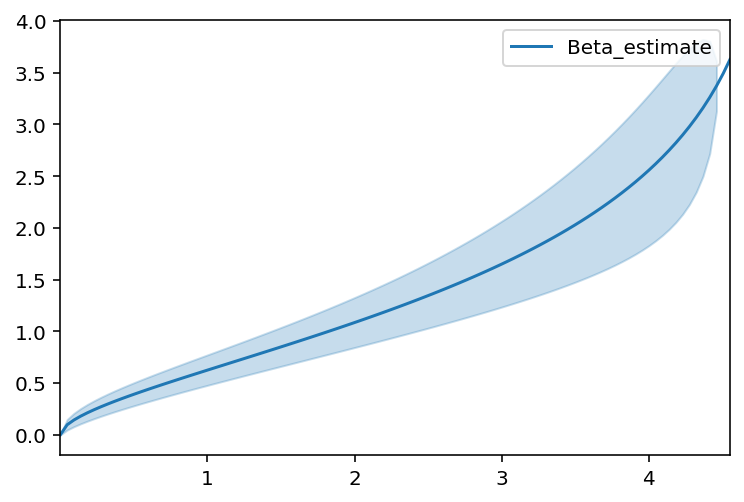

In [18]:
beta_fitter = BetaFitter().fit(T_obs, E)
beta_fitter.plot()
beta_fitter.print_summary()

## Discrete survival models

So far we have only been investigating continuous time survival models, where times can take on any positive value. If we want to consider discrete survival times (for example, over the positive integers), we need to make a small adjustment. With discrete survival models, there is a slightly more complicated relationship between the hazard and cumulative hazard. This is because there are two ways to define the cumulative hazard. 

$$H_1(t) = \sum_i^t h(t_i) $$ 

$$H_2(t) = -\log(S(t))$$

We also no longer have the relationship that $h(t) = \frac{d H(t)}{dt}$, since $t$ is no longer continuous. Instead, depending on which version of the cumulative hazard you choose to use (inference will be the same), we have to redefine the hazard function in *lifelines*. 

$$ h(t) = H_1(t) - H_1(t-1) $$
$$ h(t) = 1 - \exp(H_2(t) - H_2(t+1)) $$

[Here is an example](https://stats.stackexchange.com/questions/417303/what-is-the-likelihood-for-this-process) of a discrete survival model, that may not look like a survival model at first, where we use a redefined `_hazard` function.  


Looking for more examples of what you can build? See other unique survival models in the docs on [time-lagged survival](Modelling time-lagged conversion rates.ipynb)